| | |
|:----------|:----------|
| Name      | Bayesian Modeling |
| Notebook  | Multiple Change Point Detection |
| Author    | Joshuah Touyz, PhD |
| Version   | 0.1 |
|Last update| 02/29/20 |

In [4]:
# Load libraries
import numpy as np
from numpy.linalg import inv 
import scipy as sp
import pandas as pd
import os

# Plotting libarires
import plotnine as pn
from plotnine import *
import corner 

# Importing pymc3
import pymc3 as pm

# Supressing warnings
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

# What if we had multiple change points?
- Note we use a Metropolis sampler here because it does not play well with continuous distributions, otherwise we'd be using NUTS
- As the amount of data increases the differences between two or more switchpoints become less well defined
    - Accordingly you are likely to get "pockets of possible areas"
    - For a large number of switch points the same approach can be applied

$$
\lambda_1\sim exp(\alpha)\\
\lambda_2\sim exp(\alpha)\\
\lambda_3\sim exp(\alpha)\\
\tau_1\sim Unif(0,day_{max})\\
\tau_2\sim Unif(tau_1,day_{max})\\
\lambda_{t}=\begin{cases} \lambda_1 &\mbox{ if }t\leq\tau_1\\ \lambda_2 &\mbox{ if } t>\tau_1\end{cases}\\
\lambda_{t}=\begin{cases} \lambda_2 &\mbox{ if }t\leq\tau_2\\ \lambda_3 &\mbox{ if } t>\tau_2\end{cases}\\
Count_{t}\sim Poisson(\lambda_{t})
$$

In [10]:
import os
os.getcwd()

'/Users/joshuahtouyz/Desktop/AML_20/AML_S20CourseNotes/L6_Bayesian_Methods_2/notebooks/Workshop'

In [7]:
# Loading data
path_to_data_2 = os.path.join('path to observed_counts_2.csv')
count_data_2 = pd.read_csv(path_to_data_2).rename({'x':'time','y':'observed_counts'},axis=1)
count_data_2.head()

,time,observed_counts
0,1,2
1,2,4
2,3,4
3,4,4
4,5,6


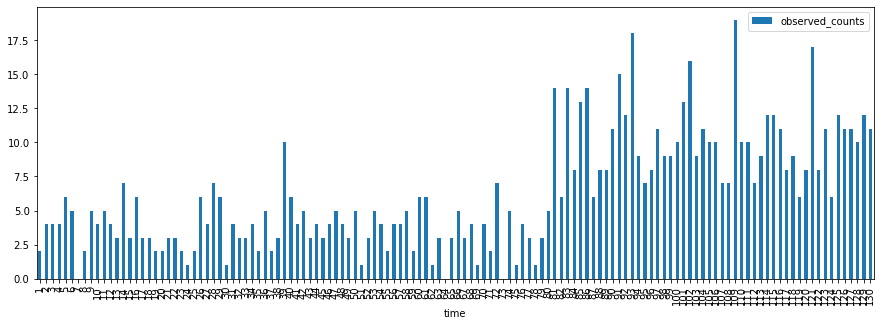

In [8]:
# - Load count data for multiple switch points -
# Loading data
#path_to_data_2 = os.path.join('path to observed_counts_2.csv')
#count_data_2 = pd.read_csv(path_to_data_2)

# Visualize the data
count_data_2.plot(x = 'time', y ='observed_counts',  kind = 'bar', figsize=(15,5))

In [9]:
# - Model constants - 
chains = 4
samples = 10000

# Setting up constants
alpha_2 = 1.0/count_data_2.observed_counts.mean()
l = len(count_data_2)

# - Model instantiation - 
adv_model = pm.Model()

with adv_model:
    id_days = count_data_2.time

    # Define priors
    lambda_1 = pm.Exponential('__________',alpha_2)
    lambda_2 = pm.Exponential('lambda_2',_____________)
    lambda_3 = pm.Exponential('lambda_3',alpha_2)
    
    switchpoint1 = pm.DiscreteUniform('switchpoint1', lower = 0, upper = l - 2)
    switchpoint2 = pm.DiscreteUniform('switchpoint2', lower = ___________, upper = l-1)

    # Define the effect from the switchpoints, order matters
    tau_1 = pm.math.switch(switchpoint1>id_days , lambda_1,_____________)
    tau_2 = pm.math.switch(_____________>id_days, tau_1, lambda_3)
    # Relationship between observed data and input
    observation = pm.Poisson("obs", tau_2, observed=count_data_2.observed_counts)

    # - Running sampler -
    step_2 = pm.Metropolis()
    trace_2 = pm.sample(draws = samples, chains = chains, tune=5000,step=step_2)

INFO (theano.gof.compilelock): Waiting for existing lock by process '16371' (I am process '14961')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/joshuahtouyz/.theano/compiledir_Darwin-19.2.0-x86_64-i386-64bit-i386-3.7.3-64/lock_dir
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint2]
>Metropolis: [switchpoint1]
>Metropolis: [lambda_3]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6151.23draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### What do our parameters look like?

In [ ]:
# - Posterior values -
lambda_1_samples =  trace_2['lambda_1']
lambda_2_samples = _____________['lambda_2']
lambda_3_samples = trace_2['lambda_3']
tau_1_samples = trace_2['switchpoint1']
tau_2_samples = trace_2['switchpoint2']

# - Posterior distribution -
posterior_dist_2 = pd.DataFrame({'lambda_1': lambda_1_samples, 
                               'lambda_2': _____________,
                               'lambda_3': lambda_3_samples,
                               'tau_1' : _____________,
                               'tau_2' : tau_2_samples})
posterior_dist_2 = posterior_dist_2.unstack().reset_index()
posterior_dist_2 = posterior_dist_2.rename(columns = {'level_0':'Parameter',
                                                  'level_1':'Sample',
                                                  0:'simulated_parameter'})

In [ ]:
# Plot options
pn.options.figure_size = (15,6)
pn.options.dpi = 100

# Plotting distribution
ggplot(aes(x = 'simulated_parameter', fill = 'Parameter'), data = posterior_dist_2)\
+ geom_histogram(bins = 70)\
+ facet_wrap(['Parameter'],scales='free')\
+ theme_bw()\
+ theme(axis_text_x = element_text(color="grey", size=10, angle=90, hjust=.5),
        axis_text_y = element_text(color="grey", size=10))

In [63]:
# Rounding to nearest 100th
posterior_dist_2['simulated_parameter'] = np.round(posterior_dist_2['simulated_parameter'],2)

# Getting MAP estimates of simulated values
MAP_estimates_2 = posterior_dist_2.groupby('Parameter').simulated_parameter.agg(pd.Series.mode)

# Getting the summarized values
out_2 = '''
---------------------------------------------------------------------
The MAP estimate for the switch point is at {switch_point_time_1}.
The MAP estimate for the switch point is at {switch_point_time_2}.
The MAP estimate for the rate BEFORE the switch point is {lambda_1}.
The MAP estimate for the rate AFTER the switch point is {lambda_2}.
The MAP estimate for the rate AFTER the switch point is {lambda_3}.
---------------------------------------------------------------------
'''.format(switch_point_time_1 = MAP_estimates_2.tau_1,
           switch_point_time_2 = MAP_estimates_2.tau_2,
          lambda_1 = MAP_estimates_2.lambda_1,
          lambda_2 = MAP_estimates_2.lambda_2,
          lambda_3 = MAP_estimates_2.lambda_3)
print(out_2)
# pm.find_MAP(model=model)


---------------------------------------------------------------------
The MAP estimate for the switch point is at 81.0.
The MAP estimate for the switch point is at 81.0.
The MAP estimate for the rate BEFORE the switch point is 3.63.
The MAP estimate for the rate AFTER the switch point is 3.57.
The MAP estimate for the rate AFTER the switch point is 10.33.
---------------------------------------------------------------------



### How are the parameters related to one another?

In [1]:
run_parameter_differences = False
# -- Plotting the bivariate plots --
if run_parameter_differences:
    vals = trace_2.varnames[3:]
    labels = [r"$\tau_1$", r"$\tau_2$", 
              r"$\lambda_1$", r"$\lambda_2$",r"$\lambda_3$"]
    samples = np.array([trace_2.get_values(p) for p in vals]).T[10000:]
    corner.corner(samples, 
                  labels= labels, 
                  quantiles= [0.25, 0.5, 0.75],
                  show_titles= True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16c421ef0>,
      dtype=object)

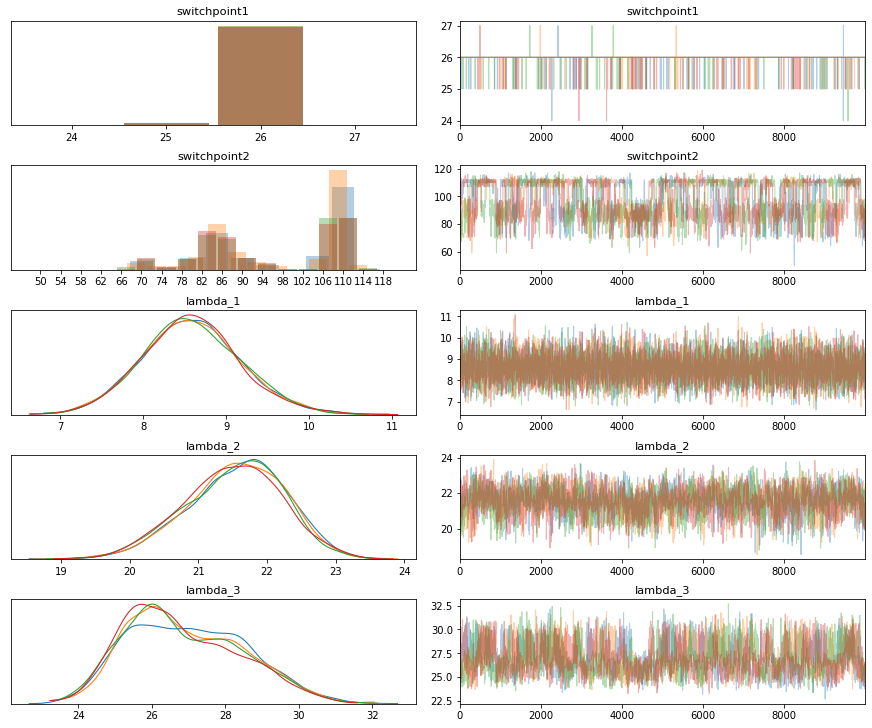

In [225]:
#pm.find_MAP(model=adv_model)
# pm.traceplot(trace_2)

### Can we model this using a continuous distribution?
- Yes, these are commonly known as regime switching models in finance

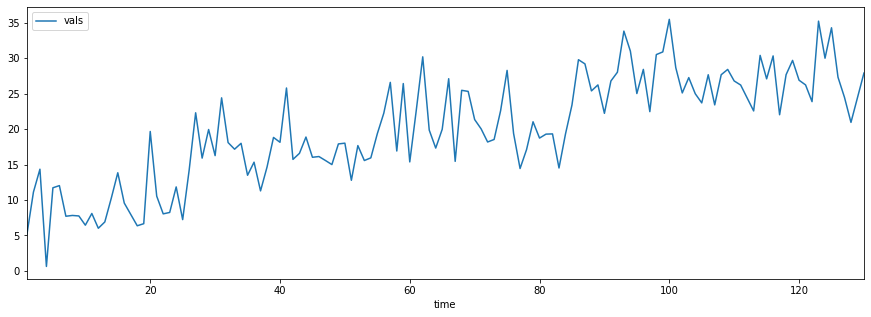

In [65]:
# - Load count data for multiple switch points -
# Loading data
path_to_data_3 = os.path.join('path to observed_counts_3.csv')
count_data_3 = pd.read_csv(path_to_data_3)

# Visualize the data
count_data_3.plot(x = 'time', y ='vals',  kind = 'line', figsize=(15,5))

In [67]:
adv_model = pm.Model()
with adv_model:
    
    id_day = count_data_3.time
    # define all of my priors
    mu1 = ___________('mu1', mu=0, sd=4)
    mu2 = pm.Normal('___________', mu=0, sd=4)
    mu3 = pm.Normal('mu3', mu=0, sd=4)
    sigma1 =___________('sigma1', sd=4)
    sigma2 = pm.HalfNormal('___________', sd=4)
    sigma3 = pm.HalfNormal('sigma3', sd=4)
    switchpoint1 = ___________('___________', lower = 0, upper = id_day.max() - 2)
    switchpoint2 = pm.DiscreteUniform('switchpoint2', lower = switchpoint1, upper = id_day.max()-1)

    # formally define the effect from the switchpoints, be careful about order! 
    tau_mu1 = pm.math.switch(switchpoint1> id_day  , mu1,mu2)
    tau_mu2 = pm.math.switch(switchpoint2>id_day, tau_mu1,___________)
    tau_sigma1 = pm.math.switch(___________> id_day , sigma1,sigma2)
    tau_sigma2 = pm.math.switch(switchpoint2>id_day, tau_sigma1,sigma3)
    
    # define the relationship between observed data and input
    y = pm.Normal('val', mu=tau_mu2, sd=tau_sigma2, observed=count_data_3.vals)
    adv_trace = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [sigma3, sigma2, sigma1, mu3, mu2, mu1]
INFO:pymc3:>NUTS: [sigma3, sigma2, sigma1, mu3, mu2, mu1]
>CompoundStep
INFO:pymc3:>CompoundStep
>>Metropolis: [switchpoint2]
INFO:pymc3:>>Metropolis: [switchpoint2]
>>Metropolis: [switchpoint1]
INFO:pymc3:>>Metropolis: [switchpoint1]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:08<00:00, 2449.10draws/s]
The acceptance probability does not match the target. It is 0.9093991183040057, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929199421152725, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
